In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import random
import numpy as np
import torch

def set_seed(seed: int):
    # Python
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Numpy
    np.random.seed(seed)

    # Torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN (중요)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # PyTorch 2.x (있으면 더 강력)
    torch.use_deterministic_algorithms(True, warn_only=True)

seed = 0
set_seed(seed)

In [26]:
import torch
import torch.nn as nn
from neuralop.data.datasets import DarcyDataset, NavierStokesDataset
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import copy
from tqdm.notebook import tqdm
import scipy.io as sio
from typing import Optional, Tuple
import torch.nn.functional as F

# 1. 데이터 불러오기
def get_dataset_loader(dataset_name, batch_size, seed=0):
    if dataset_name == "Burgers":
        root_dir = './data'
        data_file = os.path.join(root_dir, 'burgers_data_R10.mat')
        os.makedirs(root_dir, exist_ok=True)

        data = sio.loadmat(data_file)

        x_data = torch.tensor(data['a'], dtype=torch.float32)[:, ::8].unsqueeze(1)
        y_data = torch.tensor(data['u'], dtype=torch.float32)[:, ::8].unsqueeze(1)

        n_train = 1000
        n_test = 100

        train_dataset = TensorDataset(x_data[:n_train], y_data[:n_train])
        test_dataset  = TensorDataset(
            x_data[n_train:n_train+n_test],
            y_data[n_train:n_train+n_test]
        )

        g = torch.Generator()
        g.manual_seed(seed)

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            generator=g,
            num_workers=0   # 재현성 최우선
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )

    else:
        raise ValueError(f"Dataset {dataset_name} not supported yet.")

    sample_batch = next(iter(train_loader))
    in_channels  = sample_batch[0].shape[1]
    out_channels = sample_batch[1].shape[1]

    return train_loader, test_loader, in_channels, out_channels


# 2. Fine-tuning 함수
def fine_tune(model, optimizer, criterion, train_loader, lr, device):
    model.train()
    
    train_loss = 0.0
    

    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    return model, copy.deepcopy(model.state_dict()), train_loss / len(train_loader)

def studygroup(model1, model2, optimizer1, optimizer2, criterion, train_loader, lr, device):
    model1.train()
    train_loss1 = 0.0
    model2.train()
    train_loss2 = 0.0
    
    for batch in train_loader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        loss1 = criterion(outputs1, targets)
        loss2 = criterion(outputs2, targets)
        
        gap = torch.abs(outputs1 - targets) > torch.abs(outputs2 - targets)
        sign = torch.sign(outputs1 - targets) != torch.sign(outputs2 - targets)
        index1 = torch.where(torch.logical_and(gap, sign))
        index2 = torch.where(torch.logical_and(~gap, sign))
        index3 = torch.where(~sign)
        
        if index1[0].numel() > 0:
            loss1 = criterion(outputs1[index1[0], index1[1], index1[2]], outputs2[index1[0], index1[1], index1[2]].detach())
        if index3[0].numel() > 0:
            loss1 += criterion(outputs1[index3[0], index3[1], index3[2]], targets[index3[0], index3[1], index3[2]])
        loss1.backward()
        optimizer1.step()
        
        if index2[0].numel() > 0:
            loss2 = criterion(outputs2[index2[0], index2[1], index2[2]], outputs1[index2[0], index2[1], index2[2]].detach())
        if index3[0].numel() > 0:
            loss2 += criterion(outputs2[index3[0], index3[1], index3[2]], targets[index3[0], index3[1], index3[2]])        
        loss2.backward()
        optimizer2.step()

        train_loss1 += loss1.item()
        train_loss2 += loss2.item()

    return model1, model2, copy.deepcopy(model1.state_dict()), copy.deepcopy(model2.state_dict()), train_loss1 / len(train_loader), train_loss2 / len(train_loader)

# 7. 평가 함수
def evaluate(model, test_loader, device):
    # criterion = nn.MSELoss()
    # model.eval()
    # test_loss = 0.0
    # with torch.no_grad():
    #     for batch in test_loader:
    #         inputs, targets = batch["x"].to(device), batch["y"].to(device)
    #         outputs = model(inputs)
    #         test_loss += criterion(outputs, targets).item()
    # return test_loss / len(test_loader)

    model.eval()
    total_rel_l2 = 0.0
    count = 0

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            targets = batch[1].to(device)
            outputs = model(inputs)

            diff = outputs - targets

            diff_norm = torch.norm(diff.view(diff.size(0), -1), dim=1)
            target_norm = torch.norm(targets.view(targets.size(0), -1), dim=1)

            rel_l2 = diff_norm / (target_norm + 1e-12)
            total_rel_l2 += rel_l2.sum().item()
            count += rel_l2.size(0)

    return total_rel_l2 / count

class DeepONetWrapper(nn.Module):
    def __init__(self, deeponet, resolution):
        super().__init__()
        self.model = deeponet
        self.N = resolution

    def forward(self, x):
        # x: (B, 1, N)
        B, _, N = x.shape
        u_branch = x.squeeze(1)

        coord = torch.linspace(
            0, 1, N, device=x.device
        ).view(1, N, 1).repeat(B, 1, 1)

        return self.model((u_branch, coord))

In [5]:
from models.fno import FNO1D
from models.deeponet import DeepONet1D
from models.gnot import GNOT1D

set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FNO 모델 초기화
pretrained_FNO = FNO1D(modes=16, width=64, in_ch=1, out_ch=1).to(device)
pretrained_DON = DeepONetWrapper(DeepONet1D(branch_dim=1024, hidden=128, depth=3),resolution=1024).to(device)
pretrained_GNOT = GNOT1D(in_channels=1, out_channels=1, width=64, n_latents=64).to(device)


print(pretrained_model1)
print(pretrained_model3)
print(pretrained_model4)

In [27]:
def run_experiment(seed, model_type="FNO", epochs=1000):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader, _, _ = get_dataset_loader(
        "Burgers", batch_size=32, seed=seed
    )

    if model_type == "FNO":
        model = copy.deepcopy(pretrained_FNO).to(device)
    elif model_type == "DeepONet":
        model = copy.deepcopy(pretrained_DON).to(device)
    elif model_type == "GNOT":
        model = copy.deepcopy(pretrained_GNOT).to(device)
    else:
        raise ValueError("Unknown model")

    optimizer = torch.optim.Adam(
        model.parameters(), lr=1e-3, weight_decay=1e-4
    )
    criterion = nn.MSELoss()

    train_curve = []
    test_curve  = []
    best_test = float("inf")

    for epoch in tqdm(range(epochs)):
        model, _, train_loss = fine_tune(
            model, optimizer, criterion,
            train_loader, lr=1e-3, device=device
        )

        test_error = evaluate(model, test_loader, device)

        train_curve.append(train_loss)
        test_curve.append(test_error)

        best_test = min(best_test, test_error)

    return {
        "best": best_test,
        "train_curve": np.array(train_curve),
        "test_curve":  np.array(test_curve),
    }

In [28]:
seeds = [0, 1, 2, 3, 4]
results_FNO = []
results_DON = []
results_GNOT = []

for seed in tqdm(seeds):
    out = run_experiment(seed, model_type="FNO", epochs=1000)
    results_FNO.append(out)
    out = run_experiment(seed, model_type="DeepONet", epochs=1000)
    results_DON.append(out)
    out = run_experiment(seed, model_type="GNOT", epochs=1000)
    results_GNOT.append(out)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [29]:
def run_experiment_ssmo(seed, model1_type="FNO", model2_type="FNO", epochs=1000):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader, _, _ = get_dataset_loader(
        "Burgers", batch_size=32, seed=seed
    )

    if model1_type == "FNO":
        model1 = copy.deepcopy(pretrained_FNO).to(device)
    elif model1_type == "DeepONet":
        model1 = copy.deepcopy(pretrained_DON).to(device)
    elif model1_type == "GNOT":
        model1 = copy.deepcopy(pretrained_GNOT).to(device)
    else:
        raise ValueError("Unknown model1")

    if model2_type == "FNO":
        model2 = copy.deepcopy(pretrained_FNO).to(device)
    elif model2_type == "DeepONet":
        model2 = copy.deepcopy(pretrained_DON).to(device)
    elif model2_type == "GNOT":
        model2 = copy.deepcopy(pretrained_GNOT).to(device)
    else:
        raise ValueError("Unknown model2")

    optimizer1 = torch.optim.Adam(
        model1.parameters(), lr=1e-3, weight_decay=1e-4
    )
    optimizer2 = torch.optim.Adam(
        model2.parameters(), lr=1e-3, weight_decay=1e-4
    )
    criterion = nn.MSELoss()

    train_curve1 = []
    test_curve1 = []
    best_test1 = float("inf")
    train_curve2 = []
    test_curve2 = []
    best_test2 = float("inf")

    for epoch in tqdm(range(epochs)):
        model1, model2, _, _, train_loss1, train_loss2 = studygroup(model1, model2, optimizer1, optimizer2, criterion, train_loader, lr=1e-3, device=device)

        test_error1 = evaluate(model1, test_loader, device)
        test_error2 = evaluate(model2, test_loader, device)

        train_curve1.append(train_loss1)
        test_curve1.append(test_error1)
        train_curve2.append(train_loss2)
        test_curve2.append(test_error2)

        best_test1 = min(best_test1, test_error1)
        best_test2 = min(best_test2, test_error2)

    return {
        "best1": best_test1,
        "train_curve1": np.array(train_curve1),
        "test_curve1":  np.array(test_curve1),
        "best2": best_test2,
        "train_curve2": np.array(train_curve2),
        "test_curve2":  np.array(test_curve2),
    }

In [ ]:
seeds = [0, 1, 2, 3, 4]
results_FNO_FNO = []
results_DON_FNO = []
results_GNOT_FNO = []
results_DON_DON = []
results_GNOT_DON = []
results_GNOT_GNOT = []

for seed in tqdm(seeds):
    out = run_experiment_ssmo(seed, model1_type="FNO", model2_type="FNO", epochs=1000)
    results_FNO_FNO.append(out)
    out = run_experiment_ssmo(seed, model1_type="DeepONet", model2_type="FNO", epochs=1000)
    results_DON_FNO.append(out)
    out = run_experiment_ssmo(seed, model1_type="GNOT", model2_type="FNO", epochs=1000)
    results_GNOT_FNO.append(out)
    out = run_experiment_ssmo(seed, model1_type="DeepONet", model2_type="DeepONet", epochs=1000)
    results_DON_DON.append(out)
    out = run_experiment_ssmo(seed, model1_type="GNOT", model2_type="DeepONet", epochs=1000)
    results_GNOT_DON.append(out)
    out = run_experiment_ssmo(seed, model1_type="GNOT", model2_type="GNOT", epochs=1000)
    results_GNOT_GNOT.append(out)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [42]:
import csv

# CSV 파일로 저장
with open('./results/burgers1d/experiment_results_fno.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_FNO)

with open('./results/burgers1d/experiment_results_deeponet.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_DON)

with open('./results/burgers1d/experiment_results_gnot.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_GNOT)

with open('./results/burgers1d/experiment_results_fno_fno.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_FNO_FNO)

with open('./results/burgers1d/experiment_results_deeponet_fno.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_DON_FNO)

with open('./results/burgers1d/experiment_results_gnot_fno.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_GNOT_FNO)

with open('./results/burgers1d/experiment_results_deeponet_deeponet.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_DON_DON)

with open('./results/burgers1d/experiment_results_deeponet_gnot.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_GNOT_DON)

with open('./results/burgers1d/experiment_results_gnot_gnot.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerows(results_GNOT_GNOT)

print("CSV 파일 저장 완료")

CSV 파일 저장 완료


In [34]:
# DeepONet-FNO Result

test_curves1 = np.stack([r["test_curve"] for r in results_FNO], axis=0)
# shape: (num_seeds, epochs)

mean_curve1 = test_curves1.mean(axis=0)
std_curve1 = test_curves1.std(axis=0)

best_mean1 = np.mean([r["best"] for r in results_FNO])
best_std1 = np.std([r["best"] for r in results_FNO])

test_curves2 = np.stack([r["test_curve"] for r in results_DON], axis=0)
# shape: (num_seeds, epochs)

mean_curve2 = test_curves2.mean(axis=0)
std_curve2 = test_curves2.std(axis=0)

best_mean2 = np.mean([r["best"] for r in results_DON])
best_std2 = np.std([r["best"] for r in results_DON])

test_curves3 = np.stack([r["test_curve1"] for r in results_DON_FNO], axis=0)
# shape: (num_seeds, epochs)

mean_curve3 = test_curves3.mean(axis=0)
std_curve3 = test_curves3.std(axis=0)

best_mean3 = np.mean([r["best1"] for r in results_DON_FNO])
best_std3 = np.std([r["best1"] for r in results_DON_FNO])

test_curves4 = np.stack([r["test_curve2"] for r in results_DON_FNO], axis=0)
# shape: (num_seeds, epochs)

mean_curve4 = test_curves4.mean(axis=0)
std_curve4 = test_curves4.std(axis=0)

best_mean4 = np.mean([r["best2"] for r in results_DON_FNO])
best_std4 = np.std([r["best2"] for r in results_DON_FNO])

In [35]:
print(f"FNO mean: {best_mean1}")
print(f"FNO std: {best_std1}")
print(f"DeepONet mean: {best_mean2}")
print(f"DeepONet std: {best_std2}")
print(f"FNO_Ours mean: {best_mean4}")
print(f"FNO_Ours std: {best_std4}")
print(f"DeepONet_Ours mean: {best_mean3}")
print(f"DeepONet_Ours std: {best_std3}")

FNO mean: 0.020768587544560436
FNO std: 0.0002997826434041991
DeepONet mean: 0.12348028445243835
DeepONet std: 0.006422262659866466
FNO_Ours mean: 0.011142767257988453
FNO_Ours std: 0.00015055010612626652
DeepONet_Ours mean: 0.10000640374422072
DeepONet_Ours std: 0.004076267732223719


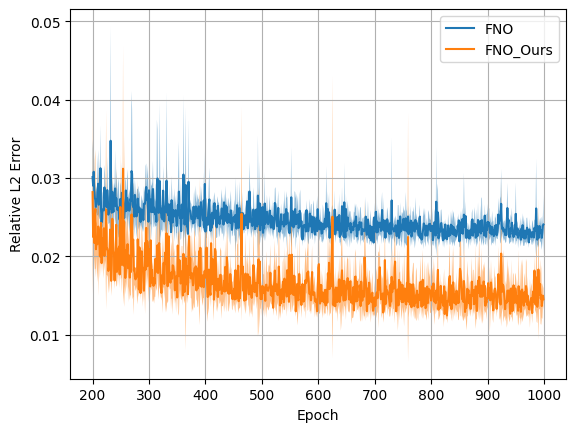

In [37]:
import matplotlib.pyplot as plt

epochs = np.arange(len(mean_curve1))

plt.plot(epochs[200:], mean_curve1[200:], label="FNO")
plt.fill_between(
    epochs[200:],
    mean_curve1[200:] - std_curve1[200:],
    mean_curve1[200:] + std_curve1[200:],
    alpha=0.5
)
plt.plot(epochs[200:], mean_curve2[200:], label="DeepONet")
plt.fill_between(
    epochs[200:],
    mean_curve2[200:] - std_curve2[200:],
    mean_curve2[200:] + std_curve2[200:],
    alpha=0.5
)
plt.plot(epochs[200:], mean_curve4[200:], label="FNO_Ours")
plt.fill_between(
    epochs[200:],
    mean_curve4[200:] - std_curve4[200:],
    mean_curve4[200:] + std_curve4[200:],
    alpha=0.5
)
plt.plot(epochs[200:], mean_curve3[200:], label="DeepONet_Ours")
plt.fill_between(
    epochs[200:],
    mean_curve3[200:] - std_curve3[200:],
    mean_curve3[200:] + std_curve3[200:],
    alpha=0.5
)

plt.xlabel("Epoch")
plt.ylabel("Relative L2 Error")
plt.legend()
plt.grid(True)

plt.show()
